In [17]:
%config Completer.use_jedi = False

## Steps:

1- Generate the binary mask from model prediction

2- Find contours and generate the pixel polygons for our binary mask

3- Knowing that our address in in the center, get the closest polygon to the center of the image
by measuring the distance betweeen the center pixel and the polygon centroids.

4- Extract our desired polygon


In [18]:
import os
import skimage
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union
import cv2
import rasterio as rio
import pycocotools.mask as mask_util
import shapely
import math
import numpy as np
import json
from shapely.geometry import Polygon, Point
import csv
import pandas as pd
from skimage import measure
from PIL import Image


In [601]:


#!/usr/bin/env python
# coding: utf-8

# In[7]:

#!/usr/bin/env python
# coding: utf-8

class Post_Process:
    def __init__(self, building_tile, xycoords, coco_file, crs_value='EPSG:4326'):
        '''
        class takes model prediction (coco json format)
        and tile_prediction(full path) of the model and location , for post processing
        Returns, binary mask and dataframe with area and oriantation
        '''
        self.coco_file = coco_file
        self.add_loc = xycoords
        self.geo_df = None
        self.building_df = None
        self.bin_mask = None
        self.result_dict = []
        self.crs_value = crs_value
        self.tile_prediction = building_tile
        
    def get_bin_mask(self):
        '''Decods the model prediction in Json format with the encoded masks
        Retruns the binary mask '''

        ## Read and parse our json file
        with open(self.coco_file, 'r') as my_file:
            data = my_file.readlines()
            # Parse file
            obj = json.loads(data[0])
            obj = json.loads(obj)
        
        #poly_loc_list = []
        ## iterate and decode segmentations
        self.bin_mask = np.zeros(np.array(obj['pred_masks'][0]).shape)

        for i in range(len(obj['boxes'])):
            seg_dict = {}
            seg_dict = {'scores': obj['scores'][i], 'pred_masks' : np.array(obj['pred_masks'][i], dtype=int)}
        
            #poly = mask_util.decode(seg_dict)[:, :]
            self.bin_mask += seg_dict['pred_masks']
            
        return  self.bin_mask
    
    def calc_azimuth(self, g):
        '''takes a geometry  and returns the angle'''        
        a = g.minimum_rotated_rectangle
        l = a.boundary
        coords = [c for c in l.coords]
        segments = [shapely.geometry.LineString([a, b]) for a, b in zip(coords,coords[1:])]
        longest_segment = max(segments, key=lambda x: x.length)

        p1, p2 = [c for c in longest_segment.coords]
        angle = math.degrees(math.atan2(p2[1]-p1[1], p2[0]-p1[0]))
        return angle
    
    def get_area(self, df):
        '''
        calculate area for our polygons and append to the geo_df
        '''
        # reproject to meter coordinates
        geo_df_meter = df.copy()
        geo_df_meter = geo_df_meter.to_crs('EPSG:3763') #5703
        # If it we have the df
        # Get the area and append to the df
        if geo_df_meter is not None :
            # Calculate the area
            area = ((geo_df_meter['geometry'].area)) # In sequare meter /10.764

        else:
            print("No dataframe acquired, yet. Use get_geo_df")
        
        return area
    
    def get_px_coords_df(self):
        #Convert ourbinary mask to polygons      
        if self.bin_mask is not None:
            contours = measure.find_contours(self.bin_mask, 0.5)
            len(contours)
            px_polys = []
            for contour in contours:
                if len(contour) > 3: # Check for valid polygons points
                    #poly.is_valid
                    poly = Polygon(contour).simplify(1.0)
                    if Polygon(contour).simplify(1.0).is_valid:
                        px_polys.append(poly)

            data = []
            boxes = self.get_bboxes()
           
            for i in range(len(px_polys)):
                data_dict = {}
                data_dict = {'value': i, 'geometry' :px_polys[i], 'bbox' : boxes[i]}
                data.append(data_dict)
            
            # Create dataFrame
            self.geo_df = gpd.GeoDataFrame(data)
            
        else:
            print("Claclulate binary mask first using get_bin_mask")
        
        self.geo_df = self.geo_df.drop(['value'], axis = 1) 
        return self.geo_df
   
    def get_px_coords(self):
        """Function to get geo coordinates given a pixel coordinates"""
        xs_list = []
        ys_list = []
        # Get thelist of pixel lat/long
        # First we get the pixel lat/long values
        self.geo_df['px_coords'] = self.geo_df['geometry'].centroid
        
        ''' 
        #Extract lat and lon from the centerpoint
        self.geo_df["pixel_x"] = self.geo_df.pixel_Center_point.map(lambda p: p.x)
        self.geo_df["pixel_y"] = self.geo_df.pixel_Center_point.map(lambda p: p.y)'''
              
        return self.geo_df


    def get_bboxes(self):
        '''Get the bbox list from our prediction json'''
        # Read the coco file and get the boxes
        ## Read and parse our json file
        with open(self.coco_file, 'r') as my_file:
            data = my_file.readlines()
            # Parse file
            obj = json.loads(data[0])
            obj = json.loads(obj)
        bbox_list = []
        for box in obj['boxes']:
            bbox_list.append(box)
        return bbox_list
    
    
    def extract_building(self, px_df, target_building= 'D:/target_building.png'):
        ''' takes pixel coordiantes dataframe and 
        Get the building closest to our building (lat/long/center) '''
        # Find the center point of an image
        im=cv2.imread(self.tile_prediction)
        center_point = [im.shape[0]/2, im.shape[1]/2]
        
        # Check the bounding box containing our center point
        target_bbox = [0, 0, 0, 0]
        for bbox in np.array(px_df.bbox):
            if (bbox[0] < center_point[0] < bbox[2]) and (bbox[1] < center_point[1] < bbox[3]):
                target_bbox = bbox
                
        return target_bbox
    
    def get_bin_mask_poly(self, mask):
        #Convert ourbinary mask to polygons      
        if mask is not None:
            contours = measure.find_contours(mask, 0.5)
            #contours = cv2.findContours(mask, cv2.RETR_EXTERNAL,
                        #cv2.CHAIN_APPROX_SIMPLE)
            len(contours)
            px_polys = []
            for contour in contours:
                if len(contour) > 3: # Check for valid polygons points
                    #poly.is_valid
                    poly = Polygon(contour).simplify(1.0)
                    if poly.is_valid:
                        px_polys.append(poly)

            data = []
           
            for i in range(len(px_polys)):
                data_dict = {}
                data_dict = {'value': i, 'geometry' :px_polys[i]}
                data.append(data_dict)
            
            # Create dataFrame
            px_df = gpd.GeoDataFrame(data)
            
        else:
            print("Claclulate binary mask first using get_bin_mask")
        
        #px_df = px_df.drop(['value'], axis = 1) 
        return px_df, contours
   
        
    
    def get_azimuth(self, df):
        #Calculate the azimuth angle
        # Make sure we already have the geo_df calculated
        list_azimuth = []
        if df is not None :
            geo_df_meter = df.copy()
            geo_df_meter = geo_df_meter.to_crs('EPSG:3763')

            for i in range(len(geo_df_meter)):
                g = geo_df_meter.iloc[i].geometry
                angle = self.calc_azimuth(g)
                list_azimuth.append(angle)       
        
        else: 
             print("No dataframe acquired, yet. Use get_geo_df")
        
        return list_azimuth
    
    
    
    # Append the information to our json file and save it somewhere
    def append_to_json(self, filename):
        '''takes a ../filename.json and 
        save the dictionary with all the information
        in a JSON file on disk'''
        ## Read and parse our json file
        with open(self.coco_file, 'r') as my_file:
            data = my_file.readlines()
            # Parse file
            obj = json.loads(data[0])
            obj = json.loads(obj)
        for i in range(len(self.geo_df)):
            seg_dict = {}
            seg_dict = {'boxes': obj['boxes'][i], 'pred_masks':obj['pred_masks'][i]}
            seg_dict['geometry'] = (np.asarray(self.geo_df.iloc[i].geometry.exterior.coords)).tolist()
            seg_dict['longitude'] =  self.geo_df.iloc[i].longitude
            seg_dict['latitude'] = self.geo_df.iloc[i].latitude
            seg_dict['area(square meter)'] = self.geo_df.iloc[i]['area(square meter)']
            seg_dict['Roof_Azimuth'] = self.geo_df.iloc[i].Roof_Azimuth       
                                    
            self.result_dict.append(seg_dict)

            with open(filename, 'w') as outfile:
                json.dump(self.result_dict, outfile)
                    
        
    # Helper method to save our list of dictionaries as a csv file
    def save_to_csv(self, file_name):
        '''Takes a file name with csv extension'''
        keys = self.result_dict[0].keys()
        with open(file_name, 'w', newline='')  as output_file:
            dict_writer = csv.DictWriter(output_file, keys)
            dict_writer.writeheader()
            dict_writer.writerows( self.result_dict)
            
    def get_geo_coords(self, df, tif_img):
        #Convert the each pixel point 
        #to a georefrenced point with lat/long coordinates
        # Now convert the pixel row/col to lat/long
        # unravel GDAL affine transform parameters
        coords = [list(poly.exterior.coords) for poly in df.geometry]
        geo_poly = []
        geo_coords = []

        for poly in coords:
            geo_poly = []
            #print(poly)
            for points in poly:
                x = points[0]
                y = points[1]
        
                (px, py) = rio.transform.xy(tif_img.transform, x, y, offset='center')
                poly = (px, py)
                geo_poly.append(poly)
        
            geo_coords.append(geo_poly)
    
        geo_polys = []    
        for poly in geo_coords:
            geo_polys.append(Polygon(poly))
        
        # Add the new polygons to our gdf
        #self.geo_df['px_polygonss'] = self.geo_df['geometry'] # The old pixel polygons
        df['geometry'] = geo_polys # assign the new polygons
        df = df.set_crs('EPSG:4326') #
        return df
    
            
    

In [633]:
work_dir = 'D:/georefrencing/[33.7758142, -84.35644359999999]/'
coco_file = 'D:/georefrencing/[33.7758142, -84.35644359999999]/final_pred.json'
pred_tile = 'D:/georefrencing/[33.7758142, -84.35644359999999]/tile_pred.png'
building_tile = 'D:/georefrencing/[33.7758142, -84.35644359999999]/building_tile.png'


### For NEARMAP

In [634]:
obj=Post_Process(building_tile, loc, coco_file)
mask = obj.get_bin_mask()

px_df = obj.get_px_coords_df()
px_df = obj.get_px_coords()
#px_df.to_csv(os.path.join(work_dir, 'px_df.csv'))
'''geo_df = px_df.drop(['px_coords', 'bbox'], axis=1)
geo_df = gpd.GeoDataFrame(geo_df)'''
'''geo_df.to_file(os.path.join(work_dir, 'px_df.geojson'), driver='GeoJSON')'''
# Extract and save our building
bbox=obj.extract_building(px_df=px_df)


In [635]:
mask = mask.astype(int)
cv2.imwrite(os.path.join(work_dir, 'mask.png'), mask)

True

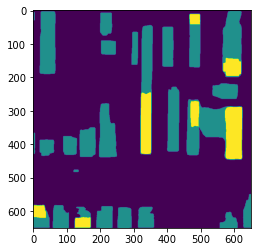

In [636]:
im = cv2.imread(os.path.join(work_dir, 'mask.png'))
plt.imshow(mask)

1


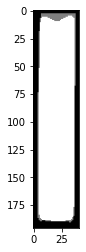

In [637]:
im=Image.open(os.path.join(work_dir, 'mask.png'))
im_crop=im.crop(bbox)

#pix_mask_img = np.array(im_crop)

im_crop.save(os.path.join(work_dir, 'target_mask.png'))
# add padding of 3 black pixels so we end up with valid polygons
im_crop_pad = np.pad(np.array(im_crop) , (3, 3), 'constant')

#t_mask = cv2.imread(os.path.join(work_dir, 'target_mask.png'), cv2.COLOR_BAYER_BG2GRAY)
#threshold = 1
#t_mask_new = np.where(t_mask/0.5>=threshold, 1, 0)
#t_mask_new_pad = np.pad(t_mask_new, (3, 3), 'constant')
plt.imshow(im_crop_pad, cmap='gray')
print(t_mask.max())

In [640]:

px_target_df, cont = obj.get_bin_mask_poly(im_crop_pad)

<AxesSubplot:>

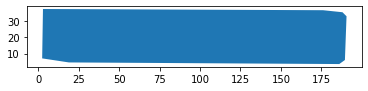

In [641]:
px_target_df.geometry.plot()

In [642]:
tif_img = rio.open("D:/SN2_buildings_train_AOI_2_Vegas_PS-RGB_img3.tif")
geo_df = obj.get_geo_coords(px_target_df, tif_img)

<AxesSubplot:>

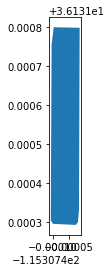

In [644]:
geo_df.geometry.plot()

In [643]:
azimuth = obj.get_azimuth(geo_df)
print(azimuth)
area = obj.get_area(geo_df)
print(area)

[-27.78916551781458]
0    1103.517458
dtype: float64


[277.06524658203125, 313.6515808105469, 359.1673278808594, 382.27880859375]

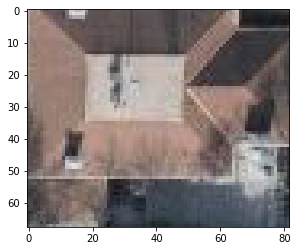

In [284]:
#bbox = np.array(px_df.iloc[6].bbox)
im=Image.open(building_tile)
im_crop=im.crop(bbox)
plt.imshow(im_crop)
bbox


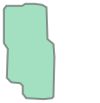

In [146]:
px_df.iloc[10].geometry

In [130]:
print(px_df.iloc[26].px_coords)

POINT (383.1660228898427 304.1148927038627)


In [132]:
'''from PIL import Image
img = Image.open(pred_tile)
plt.figure(figsize=(10, 10))
plt.imshow(np.asarray(img))
print(img.height)'''

'from PIL import Image\nimg = Image.open(pred_tile)\nplt.figure(figsize=(10, 10))\nplt.imshow(np.asarray(img))\nprint(img.height)'

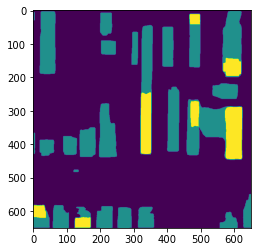

In [87]:
plt.imshow(mask)

In [137]:
'''px_df'''

'px_df'

### Old Implementation (known TIFF)

In [ ]:
obj=Post_Process('D:/building_tile.tif', addr_loc, coco_file)
mask, geo_df_full = obj.get_full_post_process()
final_pred_img, building_df = obj.zoom_in(pred_tile, 90)


geo_df_full.drop(['points'], axis=1, inplace=True)
geo_df_full.to_file("new_geo_df_full.geojson", driver='GeoJSON')

In [ ]:
final_pred_img

In [ ]:
geo_df_full_c = geo_df_full.copy()
geo_df_full_c = geo_df_full_c.to_crs(5703)
polygon_index = geo_df_full_c.distance(point).sort_values().index[0]
print(polygon_index)
print(point)

In [ ]:
for poly in orig_gdf.geometry:
    if point.within(poly):
        print('hello')

In [ ]:
geo_df_full.geometry.plot()

In [ ]:
geo_df_full.iloc[19].geometry, geo_df_full.iloc[19]['area(square meter)'], geo_df_full.iloc[19]['Roof_Azimuth']

In [ ]:
plt.imshow(final_pred_img)

In [ ]:
plt.imshow(mask, cmap='gray')

In [ ]:
geo_df_full.geometry.plot()